In [1]:
# this notebook is to utilised transfer learning to train a model on a dataset to classify between cat and dog

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os




In [6]:
# get root directory and label mapping
data_dir = '/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered'
split_dir = os.listdir(data_dir)
label_dir = os.listdir(os.path.join(data_dir, split_dir[0]))
idx_to_class = {i: j for i, j in enumerate(label_dir)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

# create transform for data augmentation: normalize, and convert to tensor
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
size = 256
data_transforms = {
    split_dir[0]: transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(), #add randomness to data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    split_dir[1]: transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
# define hyperparameters
batch_size = 10
num_epochs = 25

#show image
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [7]:
# create dataset and dataloader for training and validation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in split_dir[:1]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in split_dir[:1]}

dataset_size = {x: len(image_datasets[x]) for x in split_dir[:1]}

class_names = image_datasets[split_dir[0]].classes

print(class_names)

['cats', 'dogs']


<class 'torch.Tensor'>
torch.Size([10, 3, 256, 256])


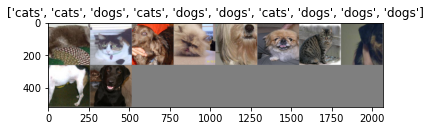

In [9]:
images, classes = next(iter(dataloaders[split_dir[0]]))
print(type(images))
print(images.shape)
imshow(torchvision.utils.make_grid(images), title = [class_names[x] for x in classes])

In [ ]:
#setting up device to run on cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")